In [4]:
import wav_handler as wh
from matplotlib import pyplot as plt
from scipy import signal
import numpy as np
import dirtools as dt

In [5]:
convertfactor = 106.373 / 1000 # +/- 2.126  / 1000 volts

def to_volts(amp):
    return convertfactor * amp


def get_resistance(name):
    num = ""
    for char in name:
        if char == "K":
            break
        num += char
    return float(num)

#get_freq("100.2Kohm")

/home/jupyter/309 workspace/309-Pool/notebooks/wav_handler.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, rawData = wavfile.read(filename)


0.009092Kohm.wav 0.0008411361
1Kohm.wav 0.0012345696
99.345Kohm.wav 0.010062987
0.0046Kohm.wav 0.0008555257
541Kohm.wav 0.023295818
298Kohm.wav 0.018077698
3.9Kohm.wav 0.0020173118
55.476Kohm.wav 0.0071976893
14.9Kohm.wav 0.0037126015
9.8Kohm.wav 0.003050027
30Kohm.wav 0.0052821585
0.018Kohm.wav 0.0008608309
0.564Kohm.wav 0.0010987163
0.0520Kohm.wav 0.000905806
0.201Kohm.wav 0.0009347657
[9.0920e+00 1.0000e+03 9.9345e+04 4.6000e+00 5.4100e+05 2.9800e+05
 3.9000e+03 5.5476e+04 1.4900e+04 9.8000e+03 3.0000e+04 1.8000e+01
 5.6400e+02 5.2000e+01 2.0100e+02]
[0.00084114 0.00123457 0.01006299 0.00085553 0.02329582 0.0180777
 0.00201731 0.00719769 0.0037126  0.00305003 0.00528216 0.00086083
 0.00109872 0.00090581 0.00093477]


Text(0, 0.5, 'RMS amplitude (V)')

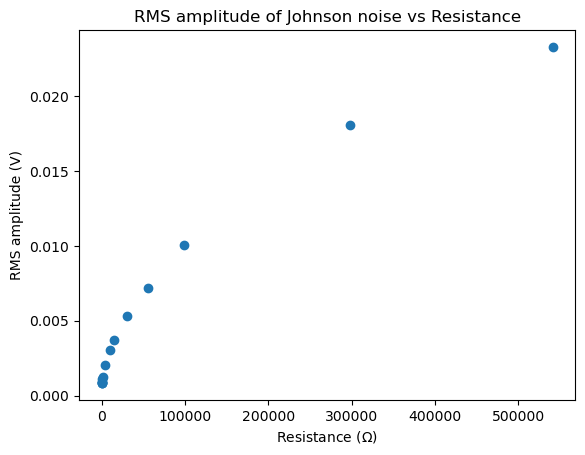

In [6]:
input_files = dt.get_files('../data_soundcard/johnson_noise/', fullpath=True)
fnames = dt.get_files('../data_soundcard/johnson_noise/')

rmses = []

for file, name in zip(input_files, fnames):
    t, d = wh.importWAV(file)
    rms = np.mean([np.sqrt(np.mean(to_volts(d["right"])**2)), np.sqrt(np.mean(to_volts(d["left"])**2))])
    print(name, rms)
    rmses.append([get_resistance(name) * 1000, rms])

rmses = np.array(rmses)
print(rmses[:,0])
print(rmses[:,1])

fig, ax = plt.subplots()

ax.set_title("RMS amplitude of Johnson noise vs Resistance")
ax.scatter(rmses[:,0], rmses[:,1])
ax.set_xlabel("Resistance ($\Omega$)")
ax.set_ylabel("RMS amplitude (V)")

In [7]:
def cross_correlate(s1, s2):
    return np.mean([s1, s2], axis=0)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

Conversion using raw data -> periodogram. Leads to a lot of noise so we will use Welch's method in between


In [51]:

from scipy.signal import argrelextrema, welch
from numpy.fft import fft, ifft
import scipy.stats
import amplifier_model as am

fs = 44100

fname = "0.564Kohm.wav"
t, d = wh.importWAV("../data_soundcard/johnson_noise/" + fname)

v = cross_correlate(d["left"], d["right"])

# no welch - raw
# f, Pxx_den = signal.periodogram(v, fs, 'boxcar', scaling='density')

f, Pxx_den = signal.welch(v, fs, nperseg=512)
print(scipy.stats.mode(np.diff(f)).mode)
gain_model_squared = am.gain50(f, *am.measured_params)**2
poly_gain_squared = am.polymod(f)**2

86.1328125


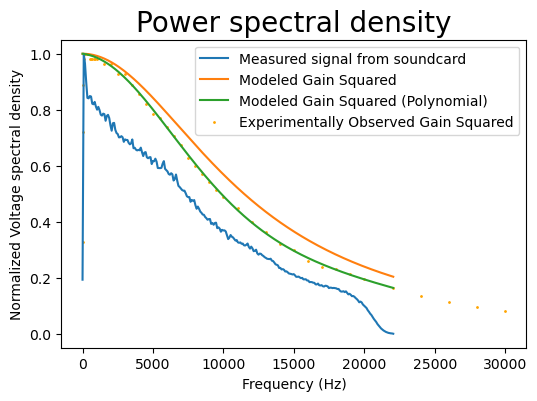

In [52]:
# PLOTTING

fig, ax = plt.subplots(figsize=(6,4))

# legacy rolling average code
# window = 1000
# ax.plot(f[:len(Pxx_den) - window + 1], (moving_average(Pxx_den, window) / np.max(moving_average(Pxx_den, window))), label="Moving Average (purely for visualization)")

# normalized data
ax.plot(f,Pxx_den / np.max(Pxx_den), label="Measured signal from soundcard")
ax.set_title('Power spectral density', fontsize=20)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Normalized Voltage spectral density')
data = np.loadtxt("../data_manual/freq_char-amp50.csv", delimiter=",", skiprows=1)
ax.plot(f, (gain_model_squared / np.max(gain_model_squared)), label="Modeled Gain Squared")
ax.plot(f, (poly_gain_squared / np.max(poly_gain_squared)), label="Modeled Gain Squared (Polynomial)")
ax.scatter(data[:,0], (data[:,4] / np.max(data[:,4]))**2,
           label="Experimentally Observed Gain Squared", c="orange",
          s=1)

ax.legend()

Apply normalization using model, truncate data to exclude aggressive filtering employed by the sound to avoid aliasing:

Text(0, 0.5, 'Power ($V^2}$)')

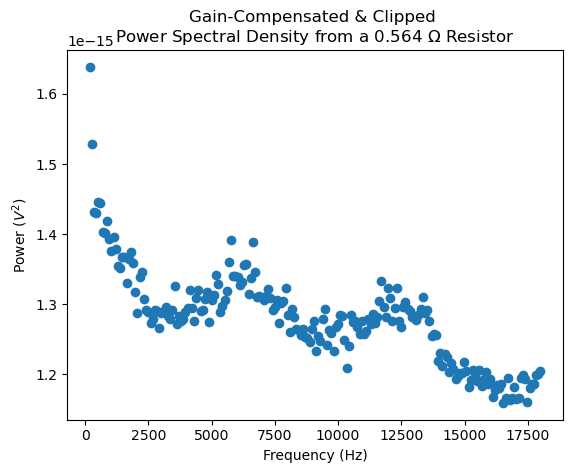

In [53]:
normalized = Pxx_den / poly_gain_squared
# truncation
start = 2
end = 210
f_clipped = f[start:210]
normalized_clipped = normalized[start:210]


fig, ax = plt.subplots()
ax.scatter(f_clipped, normalized_clipped)
ax.set_title("Gain-Compensated & Clipped \nPower Spectral Density from a {} $\\Omega$ Resistor".format(get_resistance(fname)))
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power ($V^2}$)")
# ax.vlines(f_clipped[210], 0, np.max(normalized_clipped))

Text(0, 0.5, 'Power ($V^2$)')

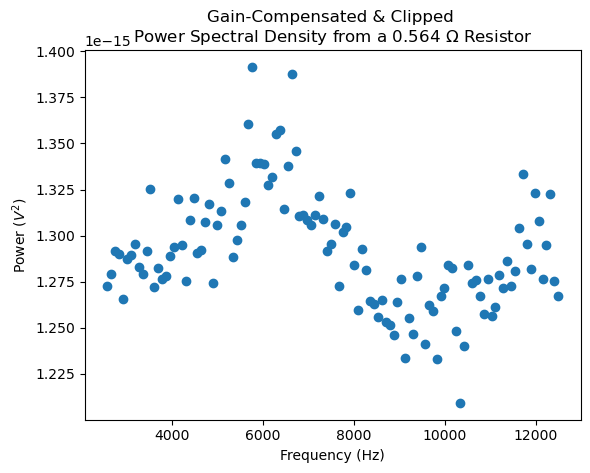

In [61]:
mask = np.where(np.logical_and(f > 2500, f < 12500))
f_clipped = f[mask]
normalized_clipped = normalized[mask]

fig, ax = plt.subplots()
ax.scatter(f_clipped, normalized_clipped)
ax.set_title("Gain-Compensated & Clipped \nPower Spectral Density from a {} $\\Omega$ Resistor".format(get_resistance(fname)))
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power ($V^2$)")
# ax.vlines(f_clipped[210], 0, np.max(normalized_clipped))


In [62]:
# calculate KB
delta_f = np.diff(f_clipped)[0]
V = np.mean(normalized_clipped)
print(np.mean(normalized_clipped)/(4 * 295 * 1000 * delta_f))

1.2708859526656043e-23


Beginnings of looking into cross-correlation

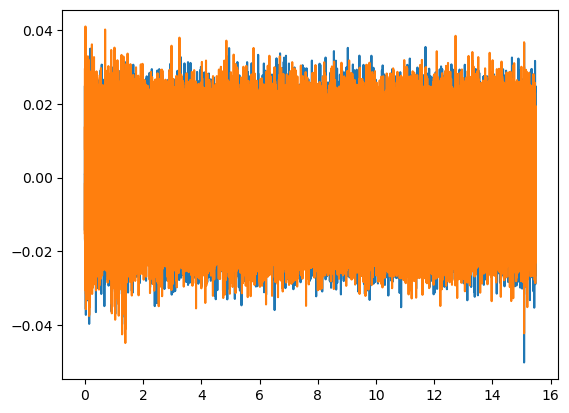

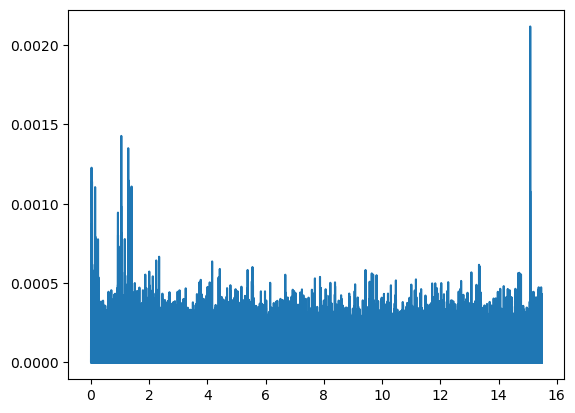

In [50]:
plt.plot(t, d["left"], t, d["right"]) # signal comparison
plt.show()
u = d["left"] * d["right"]
plt.plot(t[u >= 0], u[u >= 0])